1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

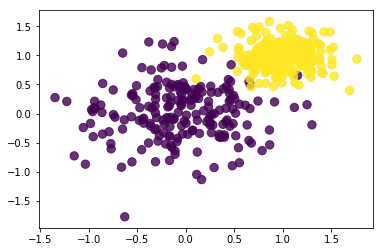

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

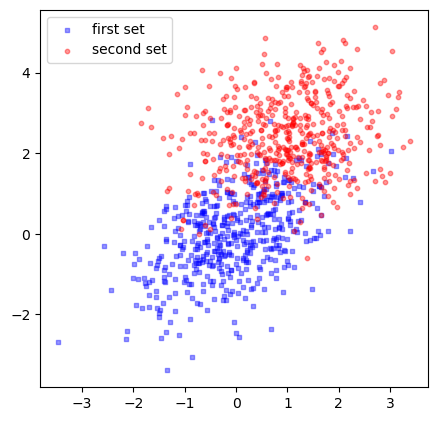

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#1st set
mean=[0,0]    #vector of means
cov=[(1, .5), (.5, 1)]    #covariance vector
set1 = np.random.multivariate_normal(mean, cov, 500)

#2nd set
mean_2=[1,2.5]    #vector of means_y
cov_2=[(1, .2), (.2, 1)]     #covariance matrix
set2 = np.random.multivariate_normal(mean_2, cov_2, 500)



#plotting
fig = plt.figure(figsize=(5,5))
fig.set_dpi(100)
#1*1 grid
ax1 = fig.add_subplot(111)



ax1.scatter((set1.T)[0], (set1.T)[1], s=10, c='b', marker="s", label='first set',alpha=0.4)
ax1.scatter((set2.T)[0], (set2.T)[1], s=10, c='r', marker="o", label='second set',alpha=0.4)
plt.legend(loc='upper left');
plt.show()


2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [3]:
#!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
import pickle
filename = "data/residuals_261.pkl"
infile = open(filename, 'rb') #reading binary file
new_dict = pickle.load(infile)  #appropriate way to read a pickle file
infile.close()

#Temporary data before removing outliers
data_temp=dict(new_dict.item())
df=pd.DataFrame(data_temp)                        #dataframe conversion
df

#selecting residuals less than <|2|
df = df[abs(df.residuals)<2]
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


Parameters:
Slope		 0.0032597701220305835 
Intercept	 -0.15432816763069473 
r_value		 0.043403510522559086
As one can see the the correlation coefficient is far from unity and is very close to zero.

This information immediately tells us that the two variables are not stongly correlated

Moreover the fact that residuals are randomly distributed with a gaussian shape around zero tells us that
the corresponding values they are related to (as function of distances) are well described by the theory



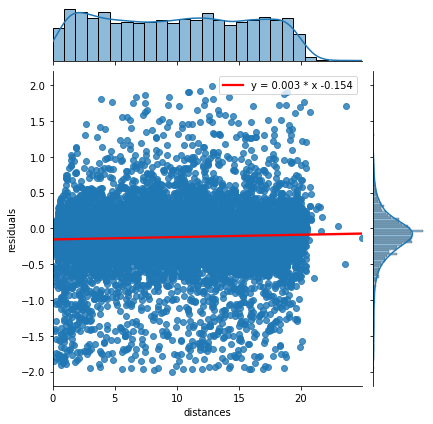

In [4]:
#Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 
res = np.asarray(df["residuals"])
dist = np.asarray(df["distances"])


from scipy import  stats
slope, intercept, r_value, p_value, std_err =  stats.linregress( df.distances, df.residuals )

seaplot=sns.jointplot(x=df.distances, y=df.residuals, kind = 'reg', marker = "o",line_kws={'color': 'red', 'label':f"y = {'%.3f'%(slope)} * x {'%.3f'%(intercept)}"}, joint_kws={'line_kws':{'color':'red'}})

#displaying coefficiencts
seaplot.ax_joint.legend()

#comments
print('Parameters:\nSlope\t\t',slope,'\nIntercept\t',intercept,'\nr_value\t\t',r_value)
print('''As one can see the the correlation coefficient is far from unity and is very close to zero.\n
This information immediately tells us that the two variables are not stongly correlated\n
Moreover the fact that residuals are randomly distributed with a gaussian shape around zero tells us that
the corresponding values they are related to (as function of distances) are well described by the theory
''')

# Manual Profile Plot

bin centers [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5 23.5 24.5]
vector of means [-0.24681325 -0.12989732 -0.17463489 -0.16243032 -0.13319177 -0.13942494
 -0.10424032 -0.07879165 -0.10530914 -0.10090854 -0.03311745 -0.0914637
 -0.07868601 -0.13182509 -0.14368135 -0.12177526 -0.13945171 -0.16790314
 -0.12161063 -0.05222069  0.062444    0.20133333  0.          0.605
 -0.12857143]
vector of std [0.48669094 0.42147642 0.42586656 0.40933695 0.3841864  0.3975971
 0.43564282 0.46042019 0.44329622 0.41961793 0.43599567 0.47110326
 0.5011134  0.4632086  0.4616865  0.45505086 0.41015543 0.42029873
 0.40704269 0.37172528 0.49557373 0.12886858 0.         1.105
 0.        ]
checking the length 25 25 25



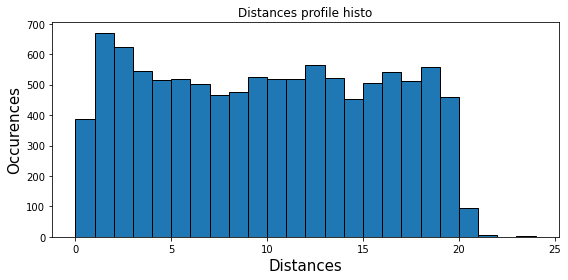

In [5]:
#manual profile plot
fig, ax = plt.subplots(figsize=(8, 4)) 
#binwidth
binw=1
bins = np.arange(0,25,binw)
h, bins, _ = ax.hist(dist, bins,edgecolor='black', linewidth=1.) # create and plot the histogram

ax.set_title('Distances profile histo')
ax.set_xlabel('Distances',fontsize=15)
ax.set_ylabel('Occurences', fontsize=15)
fig.tight_layout()

temp=np.array([]) #vector for means and std of residuals for each bin
y=np.array([]) #empty vector of means. one element for each bin
err_y=np.array([])  #empty vector of std. one element for each bin


for i in range(len(bins)):         #i dfrom 0 to 25
    for d in range(len(dist)):    #loop over the distances index
        if(dist[d]>i and dist[d]<i+(binw)):     #i'm considering each distance in the bins
            temp=np.append(temp,res[d])      #and storing all the residuals of that particular bin

    #here I have all the res in the bin I'm looping over
    if(np.size(temp)!=0):
        y=np.append(y,np.mean(temp))
        err_y=np.append(err_y,np.std(temp))
    else:
        y=np.append(y,0)
        err_y=np.append(err_y,0)
    temp=np.array([])        #make array empty again for the next bin

x=bins+binw/2
print('bin centers', x)
print('vector of means',y)
print('vector of std',err_y)
print("checking the length",len(x),len(y),len(err_y))
print()
#dist[0]
#print('\nbins:',bins,'\n')



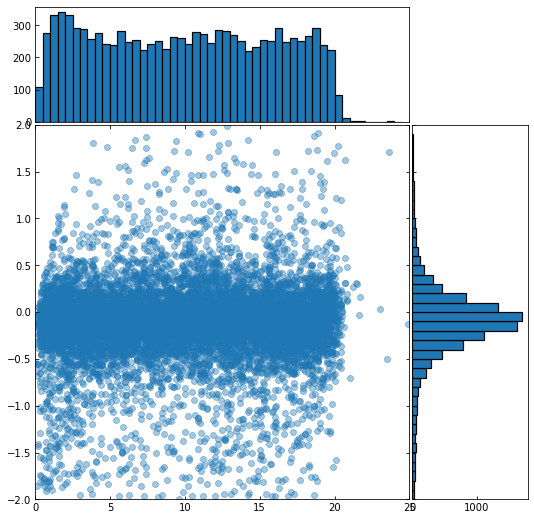

In [6]:
#commands for positions
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005  

plt.figure(figsize=(8, 8))
#definitions of the pads
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]


ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

ax_scatter.scatter(dist, res,alpha=0.4)



ax_scatter.set_xlim((0, 25))
ax_scatter.set_ylim((-2, 2))

bins = np.arange(0, 25, binw/2)
ax_histx.hist(dist, bins=bins, edgecolor='black', linewidth=1.2)
ax_histy.hist(res, bins=np.arange(-2,2,0.1), orientation='horizontal',edgecolor='black', linewidth=1.2)


#to have the same axes for the three plots
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()


[-0.24681325 -0.12989732 -0.17463489 -0.16243032 -0.13319177 -0.13942494
 -0.10424032 -0.07879165 -0.10530914 -0.10090854 -0.03311745 -0.0914637
 -0.07868601 -0.13182509 -0.14368135 -0.12177526 -0.13945171 -0.16790314
 -0.12161063 -0.05222069  0.062444    0.20133333  0.          0.605
 -0.12857143]


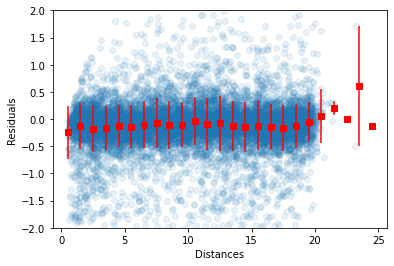

In [7]:
#using the arrays computed one can overlap teh mean and std over the scatter plot
fig=plt.figure()

ax2=fig.add_subplot(111, label="2")
ax=fig.add_subplot(111, label="1",frame_on=False)
print(y)
ax.errorbar(x, y, err_y, marker='s', linestyle='None',color='red')
ax.set_xlabel("Distances", color="black")
ax.set_ylabel("Residuals", color="black")
ax.tick_params(axis='x', colors="black")
ax.tick_params(axis='y', colors="black")
ax.set_ylim((-2, 2))

ax2.scatter(dist, res, marker='o',alpha=0.1)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_ylim((-2, 2))

plt.show()

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


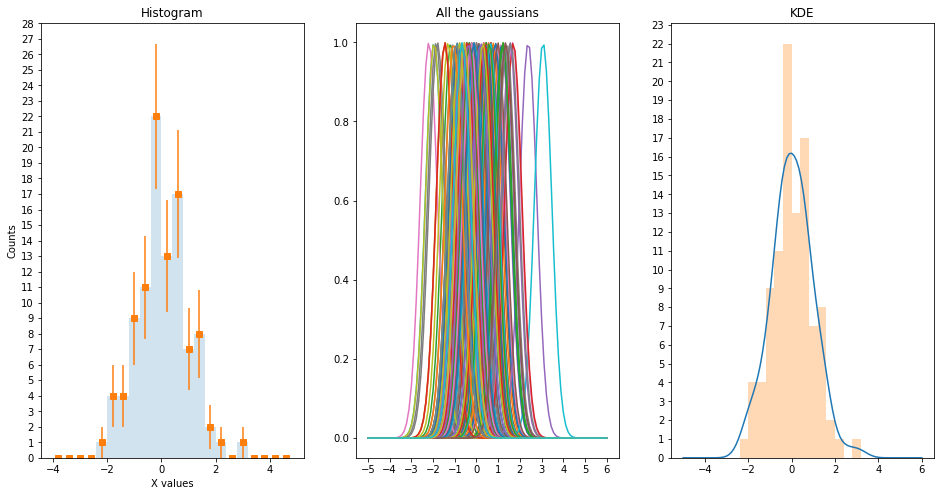

In [8]:
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy as scp
from matplotlib.ticker import MultipleLocator
from scipy.stats import norm


#array with given mean and sigma
mean=0
simga=1
N = 100
x = np.random.normal(loc=mean, scale=simga, size=N) 

#Figure with three plots for the three points
fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

#details of first plot
binwidth=0.4
#assign a tuple with 3 arrays: yvalues of histo, x gridspacing, patches
yvalues, bins, bars = ax_1.hist(x, bins = np.arange(int(x.min()-2),int(x.max()+2),binwidth), label = 'x',alpha=0.2)

ax_1.set_xlabel("X values")
ax_1.set_title('Histogram')
ax_1.set_ylabel("Counts")
#Display only integers labels with one minor tick
ax_1.yaxis.set_major_locator(MultipleLocator(1))


#assign errors
#there is one more values in bins than yvalues due to the two "boundaries"
bins = bins[0:len(bins)-1]
ax_1.errorbar(bins+binwidth/2, yvalues, yerr=np.sqrt(yvalues), marker='s', linestyle='None')

#part 2
std = 1.06*x.std()*x.size**(-0.2)
x_vector = np.linspace(int(x.min()-3),int(x.max()+3),100)
gaussians = np.array([norm(value,std).pdf(x_vector) for value in x])

ax_2.set_title("All the gaussians")
ax_2.xaxis.set_major_locator(MultipleLocator(1))
for i in gaussians: 
     ax_2.plot(x_vector, i)
        
        
        
        
#part 3
gauss_sum = np.sum(gaussians, axis = 0)
gauss_sum= (gauss_sum*binwidth*N)/scp.integrate.trapz(gauss_sum, x_vector)
ax_3.plot(x_vector, gauss_sum)
ax_3.set_title("KDE")
ax_3.yaxis.set_major_locator(MultipleLocator(1))
#ax_3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax_3.hist(x, bins = np.arange(int(x.min()-2),int(x.max()+2),0.4), label = 'x', alpha=0.3);
plt.show()


